<a href="https://colab.research.google.com/github/stepka123/ready_to_start_NL/blob/main/NL_tree_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Выводит данные датасета .csv на pandas

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import FunctionTransformer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [ ]:
# вытаскиваем тренировачный датасет и разбиваем каждую колонку на нужный нам параметр всего 43
#выделяем каждый датасет отдельно на тест и на треин
#df.head() #df.info() #df['protocol_type'].unique()
#data = df.drop('attack', axis=1)
#df.head()

columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df_train=pd.read_csv('/content/KDDTrain+.txt',header=None,names=columns)
df_test=pd.read_csv('/content/KDDTest+.txt',header=None,names=columns)
df = pd.concat([df_train, df_test])
df_train.head()

In [ ]:
#чистим будущие данные от NaN/ Null values

def clean_dataset(df_test):
    assert isinstance(df_test, pd.DataFrame), "df_test needs to be a pd.DataFrame"
    df_test.dropna(inplace=True)
    indices_to_keep = ~df_test.isin([np.nan, np.inf, -np.inf]).any(1)
    return data_test[indices_to_keep]

def clean_dataset(df_train):
    assert isinstance(df_train, pd.DataFrame), "df_train needs to be a pd.DataFrame"
    df_train.dropna(inplace=True)
    indices_to_keep = ~df_train.isin([np.nan, np.inf, -np.inf]).any(1)
    return df_train[indices_to_keep]


In [ ]:
#Дропаем дубликаты
df_dpl = df.duplicated().sum()
print("Дубликаты: ",df_dpl)
df.drop_duplicates(inplace=True)

Дубликаты:  610


#Здесь же код который я беру на тест с kagele
LSTM автоенкодер который будет оринтироваться по слассу атак, а именно разметит сам зависимости, разобьет эти зависимости на классы и будт обучатьс яуже относительно них.


In [ ]:
# changing attack labels to their respective attack class
def change_label(df):
    df.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
    df.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
    df.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
    df.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)



In [ ]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()

le_protocol_type = le1.fit(df['protocol_type'])
le_service = le2.fit(df['service'])
le_flag = le3.fit(df['flag'])

le_attack = le4.fit(df['attack'])
df['protocol_type'] = le_protocol_type.transform(df['protocol_type'])
df['service'] = le_service.transform(df['service'])
df['flag'] = le_flag.transform(df['flag'])

df['attack'] = le_attack.transform(df['attack'])

In [ ]:
from sklearn.model_selection import train_test_split
y_train= df[['attack']]
X_train= df.drop(labels=['attack'], axis=1)

print('X_train has shape:',X_train.shape,'\ny_train has shape:',y_train.shape)

X_train has shape: (147907, 42) 
y_train has shape: (147907, 1)


In [ ]:
# splitting the dataset 80% for training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.20, random_state=42)

In [ ]:
!pip install catboost


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

In [ ]:
target_names = ['normal', 'Dos', 'Probe', 'R2L', 'U2R']

In [ ]:
# Создание экземпляра классификатора наивного Байеса с гауссовскими признаками
gnb = GaussianNB()

# Обучение классификатора на обучающих данных
gnb = gnb.fit(X_train, y_train)

In [ ]:
gnb_pred = gnb.predict(X_test)  # Предсказание меток классов на тестовом наборе
gnb_pred
gnb_acc = accuracy_score(y_test, gnb_pred)  # Вычисление точности предсказаний
gnb_acc

0.3625853559597052

In [ ]:
dt = DecisionTreeClassifier()  # Создание модели дерева принятия решений
dt = dt.fit(X_train, y_train)  # Обучение модели на обучающем наборе данных

In [ ]:
dt_pred = dt.predict(X_test)
dt_pred

array([16, 27, 16, ..., 15, 14, 16])

In [ ]:
dt_acc = accuracy_score(y_test, dt_pred)
dt_acc

0.9953011966736529

In [ ]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)

<ipython-input-26-d65342ffb9ce>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train, y_train)


In [ ]:
rf_pred = rf.predict(X_test)
rf_pred


array([16, 27, 16, ..., 15, 14, 16])

In [ ]:
rf_acc = accuracy_score(y_test, rf_pred)
rf_acc

0.9973632614427692

In [ ]:
cb = CatBoostClassifier()
cb = cb.fit(X_train, y_train)

Learning rate set to 0.100937
0:	learn: 1.0413393	total: 3.05s	remaining: 50m 45s
1:	learn: 0.8995863	total: 5.2s	remaining: 43m 13s
2:	learn: 0.7940087	total: 7.37s	remaining: 40m 49s
3:	learn: 0.7087943	total: 9.48s	remaining: 39m 21s
4:	learn: 0.6338636	total: 11.6s	remaining: 38m 23s
5:	learn: 0.5724968	total: 14.8s	remaining: 40m 50s
6:	learn: 0.5222716	total: 16.8s	remaining: 39m 41s
7:	learn: 0.4706689	total: 18.8s	remaining: 38m 55s
8:	learn: 0.4253089	total: 21.2s	remaining: 38m 55s
9:	learn: 0.3900781	total: 24.2s	remaining: 39m 59s
10:	learn: 0.3612849	total: 27.1s	remaining: 40m 40s
11:	learn: 0.3321024	total: 29.4s	remaining: 40m 18s
12:	learn: 0.3091791	total: 31.4s	remaining: 39m 41s
13:	learn: 0.2869786	total: 33.3s	remaining: 39m 6s
14:	learn: 0.2667866	total: 35.3s	remaining: 38m 37s
15:	learn: 0.2472658	total: 37.3s	remaining: 38m 12s
16:	learn: 0.2319662	total: 40.3s	remaining: 38m 52s
17:	learn: 0.2184310	total: 42.3s	remaining: 38m 30s
18:	learn: 0.2046108	total: 

###Ниже код который нужно будет делать самому и под себя

In [ ]:
#преобразовываем данные в читабельном виде для нс
#protocol_type, service, flag,


In [ ]:
#url = '/content/KDDTrain+.txt'
#df = pd.read_csv("/content/KDDTrain+.txt")
#df.to_csv('KDDTrain+.txt', index=False)
#df.info()

In [ ]:
df['attack'].unique()
# changing attack labels to their respective attack class
def change_label_attack(df):
    df.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
    df.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
    df.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
    df.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

df.Label.value_counts()


change_lable_proto(df)
df.head()

Эксперименты c графиками

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

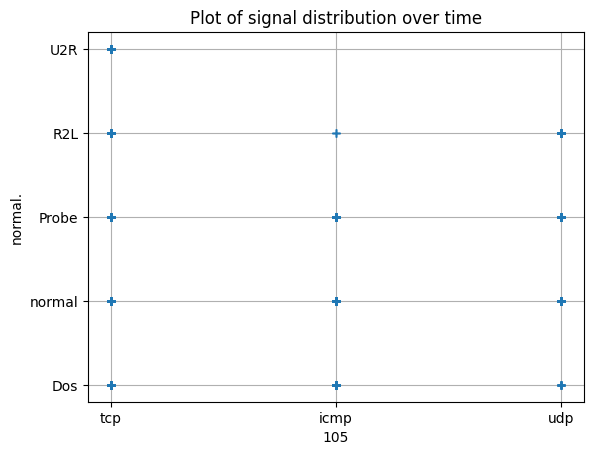

In [ ]:
plt.plot(df['protocol_type'], df['attack'], '+')
plt.xlabel('105')
plt.ylabel('normal.')
plt.title('Plot of signal distribution over time')
plt.grid(True)

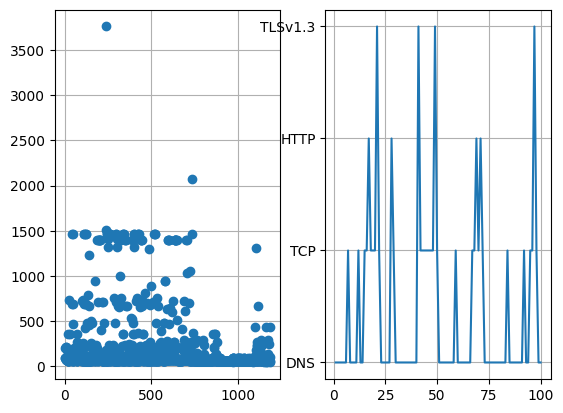

In [ ]:
plt.subplot(121)
plt.plot(df['No.'], df['Length'], 'o')
plt.grid(True)

plt.subplot(122)
plt.plot(df.head(100)['No.'], df.head(100)['Protocol'])
plt.grid(True)
plt.show()

Source	Destination	Protocol Length